In [1]:
import numpy as np
from pymatgen import Molecule
from pymatgen.io.qchem import QcTask, QcOutput
import math

# Get dihedral angle and energy from qchem files

In [2]:
import os 
import re

In [3]:
# this is not placed in utils yet because error checking hasn't been finalized
def get_energy_dihedral(directory):
    dihedral, energy = [], []
    for f in os.listdir(directory):
        if ".qcout" in f:
            if ".orig" not in f:
                output = QcOutput('{d}/{f}'.format(d=directory,f=f))
                qchem_in = output.data[-1]['input']
                try:
                    energy.append(output.final_energy)
                except IndexError:
                    energy.append('no energy') 
                constraints = qchem_in.params['opt']
                for l in constraints:
                    if 'tors' in l:
                        dihedral.append(l[len(l)-1])
    return dihedral, energy

In [4]:
dihedral, energy = get_energy_dihedral('./pt_cust_dft_full')

# Fit and plot dihedral potential

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from scipy.optimize import curve_fit

In [7]:
# Ryckaert_Bellemans dihedral potential function
def RB_potential(x, a, b, c, d, e, f):
    return (a*1.0 + b*np.cos(x*np.pi/180.0) 
            + c*(np.cos(x*np.pi/180.0)**2) 
            + d*(np.cos(x*np.pi/180.0)**3) 
            + e*(np.cos(x*np.pi/180.0)**4) 
            + f*(np.cos(x*np.pi/180.0)**5))

In [8]:
import utils

In [9]:
rel_eV_energy = utils.relative_energy(energy)

In [10]:
fit_params, fit_covar = curve_fit(RB_potential,dihedral,rel_eV_energy)

In [11]:
# create list of angles and corresponding energies
angles = np.linspace(-170, 180, 1080)
RB_energy = [RB_potential(angle, fit_params[0], fit_params[1], 
                          fit_params[2], fit_params[3], fit_params[4], 
                          fit_params[5]) for angle in angles]

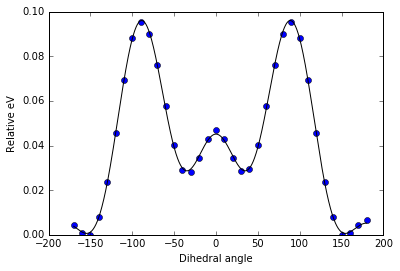

In [12]:
plt.figure()
plt.plot(dihedral, rel_eV_energy, 'o', angles, RB_energy, 'black')
plt.xlabel('Dihedral angle')
plt.ylabel('Relative eV')
plt.show()

In [13]:
fit_params

array([ 0.09589618,  0.00937093, -0.21725121,  0.00549039,  0.14653387,
        0.00507763])

# Boltzmann distribution

In [14]:
# kbT in eV/KS
kb_eV_K = 8.6173324 * 10**-5

In [15]:
kbT700 = kb_eV_K * 700.0
kbT300 = kb_eV_K * 300.0

In [16]:
# normalization 
boltz_factor_700 = [np.exp(-energy / kbT700) for energy in RB_energy]
normalize_val = sum(boltz_factor_700)

In [17]:
prob_700 = [(np.exp(-energy / kbT700) / normalize_val) for energy in RB_energy]

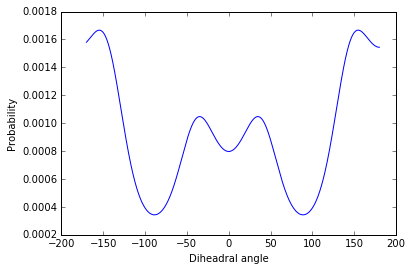

In [18]:
plt.figure()
plt.plot(angles, prob_700)
plt.xlabel('Diheadral angle')
plt.ylabel('Probability')
plt.show()

# Map dihedral angles to random numbers between 0-1

In [19]:
cum_prob = [sum(prob_700[0:prob_i]) for prob_i in range(len(prob_700))]

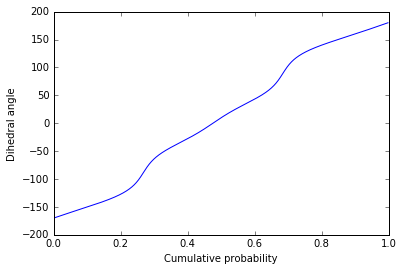

In [20]:
plt.figure()
plt.plot(cum_prob, angles)
plt.xlabel('Cumulative probability')
plt.ylabel('Dihedral angle')
plt.show()

In [21]:
from scipy.interpolate import interp1d

In [22]:
angle_map = zip(cum_prob, angles)
angle_map = interp1d(cum_prob, angles, kind='cubic')

# Build, relax, and sample neutral chain

In [23]:
from polymer_chain import Polymer

In [24]:
monomer_num = 25
monomer_len = 2.548
link_len = 1.480
link_angle = 15.0
dihedral_set = angle_map(np.random.uniform(0,1, size=(monomer_num-1)))
sample_num = 10000

In [25]:
pt_neutal = Polymer(monomer_num, monomer_len, link_len, link_angle, dihedral_set, sample_num)

In [26]:
ave_ete, ave_corr = pt_neutal.sample_neutral_chains()

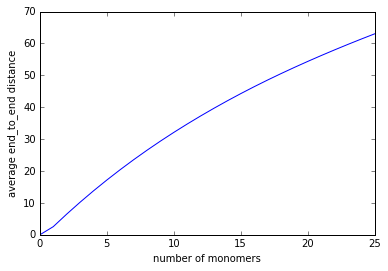

In [27]:
plt.figure()
plt.plot(range(0, monomer_num + 1, 1), ave_ete)
plt.xlabel('number of monomers')
plt.ylabel('average end_to_end distance')
plt.show()

In [28]:
#%timeit pt_neutal.sample_neutral_chains()

In [29]:
#1 loop, best of 3: 667 ms per loop

In [30]:
ave_ete

array([  0.        ,   2.548     ,   6.46975014,  10.2029984 ,
        13.76640663,  17.1706266 ,  20.4249298 ,  23.53807459,
        26.51810258,  29.3725167 ,  32.10900983,  34.73475575,
        37.25743619,  39.68379036,  42.02225879,  44.27259483,
        46.43939949,  48.5263327 ,  50.53836706,  52.48557455,
        54.37137703,  56.20039713,  57.97893945,  59.70791859,
        61.39098616,  63.02765799])

In [31]:
# array([  0.        ,   2.548     ,   6.46982458,  10.19999563,
        #13.75767345,  17.15417029,  20.39533452,  23.50273109,
        #26.47750789,  29.33536897,  32.11542456,  34.79554421,
        #37.34805674,  39.83675646,  42.2354071 ,  44.55479335,
        #46.80223247,  49.02154735,  51.14895552,  53.16663125,
        #55.14798765,  57.06367487,  58.90902885,  60.68290171,
        #62.34887949,  64.01163214])

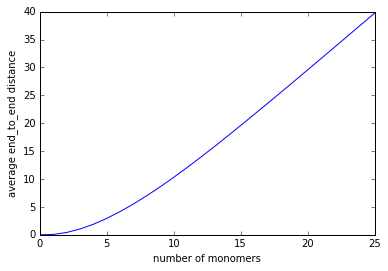

In [32]:
plt.figure()
plt.plot(range(0, monomer_num + 1, 1), ((ave_ete * ave_ete)*0.01))
plt.xlabel('number of monomers')
plt.ylabel('average end_to_end distance')
plt.show()

In [33]:
print range(0, 10, 2)

[0, 2, 4, 6, 8]


In [34]:
tt = [10, 6, 7, 3]
len(tt)

4

In [35]:
print range(0, 4, 2)

[0, 2]


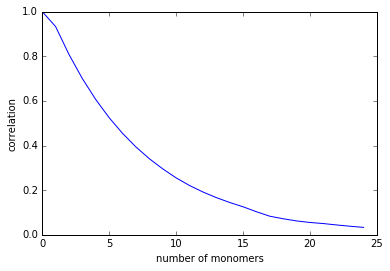

In [36]:
plt.figure()
plt.plot(range(0, monomer_num, 1), ave_corr)
plt.xlabel('number of monomers')
plt.ylabel('correlation')
plt.show()

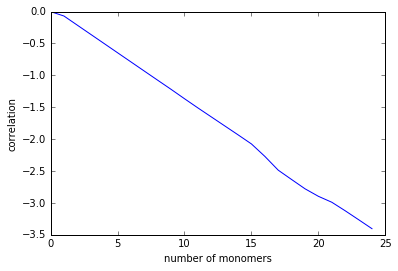

In [37]:
plt.figure()
plt.plot(range(0, monomer_num, 1), np.log(ave_corr))
plt.xlabel('number of monomers')
plt.ylabel('correlation')
plt.show()

In [38]:
ln_corr = np.log(ave_corr)

In [39]:
ln_corr[24] / -24.0

0.14183918929641665

In [40]:
np.polyfit(range(0, monomer_num, 1), ln_corr, 1)

array([-0.14651528,  0.0791921 ])

In [41]:
-1. / -0.14676288

6.813712023094667

In [42]:
6.813712023094667 * 0.399597

2.7227388832925596

In [43]:
charged_fit_params = np.array([ 0.52573396,  0.0170634 , -0.82161005,  0.00157422,  0.32503028,
        0.00441117])

In [51]:
new_fit_params = (fit_params + charged_fit_params) / 2

In [52]:
new_fit_params

array([ 0.31081507,  0.01321716, -0.51943063,  0.0035323 ,  0.23578208,
        0.0047444 ])

In [53]:
# create list of angles and corresponding energies
angles = np.linspace(-170, 180, 1080)
interp_energy = [RB_potential(angle, new_fit_params[0], new_fit_params[1], 
                          new_fit_params[2], new_fit_params[3], new_fit_params[4], 
                          new_fit_params[5]) for angle in angles]

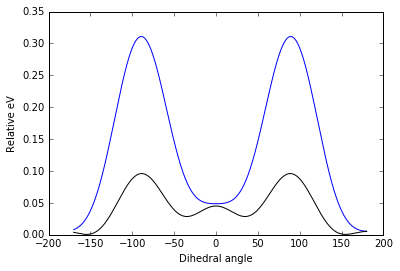

In [56]:
plt.figure()
plt.plot(angles, interp_energy, 'blue', angles, RB_energy, 'black')
plt.xlabel('Dihedral angle')
plt.ylabel('Relative eV')
plt.show()